# 0. Attaching libraries

In [2]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [3]:
from dateutil.relativedelta import relativedelta
import builtins

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Reading the core Dataset from the golden source

In [6]:
csv_file  = "https://raw.githubusercontent.com/mithridata-com/NOVAIMS_BDMwDS_PROJECT/refs/heads/main/00%20Data/Dataset.csv?token=GHSAT0AAAAAADEUY5L67SA3ZFHKQZRP2KIM2CHCNUA"

excel_path  = (r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\02 Output\01 TB Customer Analysis Data.xlsx")
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [ ]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

In [ ]:
print(df.head())      # first few rows

In [ ]:
df.columns

In [211]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [212]:
tb_df = df.loc[(df["affinity_name"] == "T&B") & (df["conv"] == 1)].copy()

In [213]:
tb_df

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv,churn,customer_id
952,T&B,Policycreated,1950,10295.0,10608,4634,1966-04-01,RENAULT,2019-02-07,2019-02-07,...,1.0,3.0,5.0,1.0,4.0,6.0,5.0,1,0,10608-4634-WOENSDRECHT-1966-04-01-M
1109,T&B,Policycreated,2106,10344.0,10684,4838,1956-08-01,FORD,2019-03-04,2019-03-04,...,2.0,4.0,5.0,2.0,6.0,6.0,5.0,1,0,10684-4838-BREDA-1956-08-01-M
1120,T&B,Policycreated,2116,10347.0,10682,3223,1947-02-01,NISSAN,2019-03-05,2019-03-31,...,3.0,4.0,3.0,1.0,5.0,4.0,5.0,1,0,10682-3223-HELLEVOETSLUIS-1947-02-01-M
1220,T&B,Policycreated,1645,10382.0,10749,3823,1953-10-01,OPEL,2019-03-18,2019-03-18,...,2.0,3.0,5.0,4.0,5.0,6.0,5.0,1,0,10749-3823-AMERSFOORT-1953-10-01-M
1237,T&B,Policycreated,2229,10387.0,10762,9733,1978-07-01,OPEL,2019-03-19,2019-03-19,...,1.0,1.0,4.0,3.0,2.0,2.0,2.0,1,0,10762-9733-GRONINGEN-1978-07-01-F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,T&B,Policycreated,9203,11908.0,15362,2526,1965-06-01,TOYOTA,2020-02-28,2020-02-28,...,3.0,3.0,5.0,6.0,6.0,6.0,5.0,1,-1,15362-2526-nan-1965-06-01-nan
9195,T&B,Policycreated,9204,11909.0,15428,3082,1958-11-01,OPEL,2020-02-28,2020-02-28,...,2.0,2.0,4.0,4.0,2.0,1.0,1.0,1,-1,15428-3082-nan-1958-11-01-nan
9199,T&B,Policycreated,9215,11912.0,15436,3992,1995-06-01,OPEL,2020-02-28,2020-02-28,...,2.0,3.0,4.0,4.0,4.0,4.0,4.0,1,-1,15436-3992-nan-1995-06-01-nan
9205,T&B,Policycreated,9245,11917.0,12057,7463,1998-10-01,PEUGEOT,2020-02-29,2020-02-29,...,1.0,3.0,6.0,2.0,6.0,6.0,5.0,1,-1,12057-7463-nan-1998-10-01-nan


In [214]:
pd.pivot_table(
    tb_df, 
    values=["policy_number"],
    index=["churn","conv"],
    columns=["affinity_name"],
    aggfunc=lambda x: len(x.unique()),
)

,,policy_number
,affinity_name,T&B
churn,conv,
-1,1,191
0,1,248
1,1,56


# CHAPTER 1. CUSTOMER PROFILING

## CHAPTER 1.1. DEMOGRAPHICS

### 1.1.1. AGE

In [215]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [216]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
tb_df["birth_date"] = pd.to_datetime(tb_df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
tb_df["age"] = tb_df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
tb_df["age"] = pd.to_numeric(tb_df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [217]:
tb_df["age_band"] = pd.cut(tb_df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

# ── 4. Pivot table: customers per age band ──────────────────────────────────
age_pivot = (
    tb_df
    .pivot_table(index="age_band",
                 values=["customer_id","policy_number"],       # swap for any non-null column
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers","policy_number": "num_policies"})
    .reset_index()
)

In [218]:
age_pivot

,age_band,num_customers,num_policies
0,<25,111,113
1,25–34,177,183
2,35–44,71,72
3,45–54,51,52
4,55–64,47,47
5,65+,28,28
6,Total,485,495


In [219]:
tb_df["age"].mean()

np.float64(36.002020202020205)

In [220]:
tb_df["age"].median()

np.float64(30.0)

### 1.1.2. GENDER

In [221]:
tb_df["gender_norm"] = (
    tb_df["gender"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"M": "Male", "F": "Female"})
)

In [222]:
# ── 4️⃣  PIVOT  – overall count by gender ──────────────────────────────────
gender_pivot = (
    tb_df
    .pivot_table(index="gender_norm",
                 values=["customer_id","policy_number"],          # any non-null column works
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers","policy_number": "num_policies"})
    .reset_index()
)

gender_pivot

,gender_norm,num_customers,num_policies
0,Female,87,88
1,Male,156,160
2,N,242,247
3,Total,485,495


### 1.1.3. RESIDENCE

In [223]:
# ── 4️⃣  PIVOT  – overall count by residence ──────────────────────────────────
residence_pivot = (
    tb_df
    .pivot_table(index="PROVINCE",
                 values=["customer_id","policy_number"],          # any non-null column works
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers","policy_number": "num_policies"})
    .reset_index()
    .sort_values(by="num_customers", ascending=False)
)

residence_pivot

,PROVINCE,num_customers,num_policies
12,Total,485,495
9,South Holland,153,155
3,Gelderland,72,74
10,Utrecht,59,60
7,North Holland,59,61
8,Overijssel,55,57
6,North Brabant,30,31
4,Groningen,23,23
5,Limburg,11,11
2,Friesland,9,9


### 1.1.4. INCOME

In [224]:
tb_df["income_norm"] = (
    tb_df["INCOME"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-High", "2": "2-Mid-High", "3": "3-Mid", "4": "4-Mid-Low", "5": "5-Low", "6": "6-Mixed or NA","N": "6-Mixed or NA"})
)

In [225]:
# ── 4️⃣  PIVOT  – overall count by residence ──────────────────────────────────
income_pivot = (
    tb_df
    .pivot_table(index="income_norm",
                 values=["customer_id","policy_number"],          # any non-null column works
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers","policy_number": "num_policies"})
    .reset_index()
    #.sort_values(by="income_norm", ascending=False)
)

income_pivot

,income_norm,num_customers,num_policies
0,1-High,35,35
1,2-Mid-High,104,109
2,3-Mid,126,128
3,4-Mid-Low,128,129
4,5-Low,35,36
5,6-Mixed or NA,57,58
6,Total,485,495


### 1.1.5. Ubranization

In [226]:
tb_df["urb_norm"] = (
    tb_df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [227]:
urb_pivot = (
    tb_df
    .pivot_table(index= ["urb_norm"],
                 values=["customer_id", "policy_number"],  
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers", "policy_number": "num_policies"})
    .reset_index()
    #.sort_values(by="avg_urbanization", ascending=True)
)

urb_pivot

,urb_norm,num_customers,num_policies
0,1-VeryHigh,128,131
1,2-High,71,71
2,3-Mid-to-High,73,74
3,4-Mid,89,92
4,5-Mid-to-Low,43,44
5,6-Low,38,40
6,7-VeryLow,43,43
7,Total,485,495


## CHAPTER 1.2. VEHICLE

### 1.2.1. Brand mix

In [228]:
num_cars = (
    tb_df
    .pivot_table(index= ["customer_id"],
                 values=["brand"],  
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"brand": "num_of_brands"})
    .reset_index()
    .sort_values(by="num_of_brands", ascending=False)
)

num_cars

,customer_id,num_of_brands
485,Total,34
455,14940-7468-nan-1987-05-01-nan,2
53,11328-6903-nan-1991-09-01-nan,2
211,11886-1971-YMUIDEN-1995-02-01-M,2
229,11955-6852-HUISSEN-1987-04-01-M,2
...,...,...
17,11069-3073-ROTTERDAM-1993-05-01-M,1
18,11070-2804-GOUDA-1995-02-01-F,1
19,11082-1068-AMSTERDAM-1961-01-01-M,1
20,11085-3087-ROTTERDAM-1997-01-01-M,1


In [229]:
brand_pivot = (
    tb_df
    .pivot_table(index= ["brand"],
                 values=["customer_id"],  
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"customer_id": "num_customers"})
    .reset_index()
    .sort_values(by="num_customers", ascending=False)
)

brand_pivot

,brand,num_customers
34,Total,485
32,VOLKSWAGEN,75
21,OPEL,49
22,PEUGEOT,46
23,RENAULT,39
26,SEAT,28
9,FORD,28
4,CITROEN,27
8,FIAT,20
2,BMW,20


In [230]:
# Assuming `df` is your DataFrame with `builddate_car` and `policy_start_date` columns
# Convert columns to datetime if not already
tb_df['builddate_car'] = pd.to_datetime(tb_df['builddate_car'])
tb_df['policy_start_date'] = pd.to_datetime(tb_df['policy_start_date'])

In [231]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

# 2) Map your buildmonth_car column through this dictionary
#    Any month not in month_map will become NaN (so you can catch typos).
tb_df["month_num"] = tb_df["buildmonth_car"].map(month_map)

# 3) (Optional) Check if any buildmonth_car was invalid / unmapped:
invalid_months = tb_df[tb_df["month_num"].isna()][["buildmonth_car"]].drop_duplicates()
if not invalid_months.empty:
    print("Warning: These buildmonth_car values did not match any key in month_map:\n", invalid_months)

# 4) Create a YYYY-MM-01 string by concatenating buildyear_car, month_num, and “01”
#    First ensure buildyear_car is a string (in case it was int)
tb_df["year_str"] = tb_df["buildyear_car"].astype(str).str[:4]

In [232]:
tb_df["year_str"].head()

952     2011
1109    2009
1120    2011
1220    2003
1237    2001
Name: year_str, dtype: object

In [233]:
#    Now build the “YYYY-MM-01” string
tb_df["builddate_str"] = tb_df["year_str"] + "-" + tb_df["month_num"] + "-01"

# 5) Convert that string into an actual datetime column
#    If any builddate_str is malformed (e.g. month_num was NaN), errors='coerce' will yield NaT.
tb_df["builddate_car_funnel"] = pd.to_datetime(
    tb_df["builddate_str"],
    format="%Y-%m-%d",
    errors="coerce"
)

# 6) (Optional) See which rows failed conversion
failed_parsing = tb_df[tb_df["builddate_car_funnel"].isna() & tb_df["builddate_str"].notna()]
if not failed_parsing.empty:
    print("These rows couldn’t be parsed into YYYY-MM-01:\n", 
          failed_parsing[["buildyear_car", "buildmonth_car", "builddate_str"]].head())

# 7) Clean up any helper columns, if you’d like
tb_df.drop(columns=["month_num", "year_str", "builddate_str"], inplace=True)

# 8) Inspect results
print(tb_df[["buildyear_car", "buildmonth_car", "builddate_car_funnel"]].head(10))
print("\nData type of builddate_car_funnel:", tb_df["builddate_car_funnel"].dtype)

      buildyear_car buildmonth_car builddate_car_funnel
952          2011.0        January           2011-01-01
1109         2009.0            May           2009-05-01
1120         2011.0          March           2011-03-01
1220         2003.0          March           2003-03-01
1237         2001.0      September           2001-09-01
1249         2013.0        January           2013-01-01
1348         2005.0          April           2005-04-01
1391         2011.0           July           2011-07-01
1405         2000.0          March           2000-03-01
1460         2007.0       December           2007-12-01

Data type of builddate_car_funnel: datetime64[ns]


In [234]:
tb_df['builddate_car'] = tb_df['builddate_car'].fillna(tb_df['builddate_car_funnel'])

In [235]:
tb_df['builddate_car'].head()

952    2011-01-01
1109   2009-05-01
1120   2011-03-01
1220   2003-03-01
1237   2002-09-01
Name: builddate_car, dtype: datetime64[ns]

In [236]:
tb_df['policy_start_date'].head()

952    2019-02-09
1109   2019-03-05
1120   2019-04-01
1220   2019-03-20
1237   2019-04-01
Name: policy_start_date, dtype: datetime64[ns]

In [237]:
print(tb_df[['builddate_car', 'policy_start_date']].dtypes)

builddate_car        datetime64[ns]
policy_start_date    datetime64[ns]
dtype: object


In [238]:
# Calculate current date
today = current_date

# Calculate car_age
tb_df['car_age'] = today.year - tb_df['builddate_car'].dt.year - (
    (today.month < tb_df['builddate_car'].dt.month) |
    ((today.month == tb_df['builddate_car'].dt.month) & (today.day < tb_df['builddate_car'].dt.day))
).astype(int)

In [239]:
# Calculate car_age_when_insured
mask_insured = (
    (tb_df['policy_start_date'].dt.month < tb_df['builddate_car'].dt.month) |
    ((tb_df['policy_start_date'].dt.month == tb_df['builddate_car'].dt.month) & 
     (tb_df['policy_start_date'].dt.day < tb_df['builddate_car'].dt.day))
)
tb_df['car_age_when_insured'] = (
    tb_df['policy_start_date'].dt.year - tb_df['builddate_car'].dt.year - mask_insured.astype(int)
)

# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
tb_df['car_age_norm'] = pd.cut(tb_df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")
tb_df['car_age_when_insured_norm'] = pd.cut(tb_df['car_age_when_insured'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")

# Display resulting DataFrame head to verify
print(tb_df[['builddate_car', 'policy_start_date', 'car_age', 'car_age_norm', 
          'car_age_when_insured', 'car_age_when_insured_norm']].head())

     builddate_car policy_start_date  car_age car_age_norm  \
952     2011-01-01        2019-02-09        8         8-11   
1109    2009-05-01        2019-03-05       10         8-11   
1120    2011-03-01        2019-04-01        8         8-11   
1220    2003-03-01        2019-03-20       16          12+   
1237    2002-09-01        2019-04-01       17          12+   

      car_age_when_insured car_age_when_insured_norm  
952                      8                      8-11  
1109                     9                      8-11  
1120                     8                      8-11  
1220                    16                       12+  
1237                    16                       12+  


In [240]:
age_cars = (
    tb_df
    .pivot_table(index= ["car_age_norm","car_age_when_insured_norm"],
                 values=["policy_number"],  
                 #columns=["car_age_when_insured_norm"],
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"policy_number": "value"})
    .reset_index()
    #.sort_values(by="num_of_customers", ascending=False)
)

age_cars

,car_age_norm,car_age_when_insured_norm,value
0,0-3,0-3,23.0
1,4-7,0-3,1.0
2,4-7,4-7,93.0
3,4-7,8-11,3.0
4,8-11,4-7,7.0
5,8-11,8-11,87.0
6,8-11,12+,1.0
7,12+,8-11,2.0
8,12+,12+,275.0
9,Unknown,0-3,3.0


### 1.2.3. Car price

In [241]:
# 1. Define your bin edges (in currency units):
#    0–5 000, 5 000–10 000, 10 000–20 000, 20 000–35 000, and 35 000+
bins = [0, 5000, 10000, 20000, 35000, np.inf]

# 2. Define labels for each bin
labels = ['<=5k', '5k-10k', '10k-20k', '20k-35k', '35k+']

# 3. Create a new categorical column “worth_car_bin”
tb_df['worth_car_bin'] = pd.cut(
    tb_df['worth_car'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 4. (Optional) If you want to flag rows where worth_car was missing → assign "Unknown"
tb_df['worth_car_bin'] = tb_df['worth_car_bin'].cat.add_categories('Unknown') \
                                             .fillna('Unknown')

In [242]:
prices_cars = (
    tb_df
    .pivot_table(index= ["worth_car_bin"],
                 values=["policy_number"],  
                 #columns=["car_age_when_insured_norm"],
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"policy_number": "value"})
    .reset_index()
    #.sort_values(by="num_of_customers", ascending=False)
)

prices_cars

,worth_car_bin,value
0,<=5k,0
1,5k-10k,25
2,10k-20k,133
3,20k-35k,56
4,35k+,33
5,Unknown,248
6,Total,495


### 1.2.4. Car fuel modes

In [243]:
tb_df["fuel_car"] = tb_df["fuel_car"].fillna("NA")

In [244]:
fuel_cars = (
    tb_df
    .pivot_table(index= ["fuel_car"],
                 values=["policy_number"],  
                 #columns=["car_age_when_insured_norm"],
                 aggfunc=lambda x: len(x.unique()),
                 margins=True,
                 margins_name="Total")
    .rename(columns={"policy_number": "value"})
    .reset_index()
    #.sort_values(by="num_of_customers", ascending=False)
)

fuel_cars

,fuel_car,value
0,DIESEL,68
1,GASOLINE,177
2,HYBR/GAS,2
3,LPG,1
4,NA,247
5,Total,495


### POLICY TYPE

### COHORT ANALYSIS

In [245]:
tb_df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

In [246]:
# 1) Make sure `policy_start_date` is a datetime:
tb_df['policy_start_date'] = pd.to_datetime(
    tb_df['policy_start_date'],
    errors='coerce'
)

# 2) Group by `customer_id` and take the minimum `policy_start_date`
first_policy = (
    tb_df
    .groupby('policy_number', as_index=False)['policy_start_date']
    .min()
    .rename(columns={'policy_start_date': 'first_policy_date'})
)

# 3) From that min date, extract the quarter (e.g. “2021Q1”, “2021Q2”…)
#    We’ll use pandas’ Period functionality for a clean “YYYYQ#” string.
first_policy['cohort'] = first_policy['first_policy_date'].dt.to_period('m').astype(str)  

# 4) Merge the cohort_quarter back onto tb_df
tb_df = tb_df.merge(
    first_policy[['policy_number', 'cohort']],
    on='policy_number',
    how='left'
)

# 5) (Optional) If you’d rather have cohort_quarter as a pandas PeriodDtype instead of string:
# first_policy['cohort_quarter'] = first_policy['first_policy_date'].dt.to_period('Q')
# then merge that. In that case, tb_df['cohort_quarter'] will be dtype “period[Q-DEC]”

# 6) (Optional) Inspect the result
print(tb_df[['policy_number', 'policy_start_date', 'cohort']].head(10))

   policy_number policy_start_date   cohort
0        10295.0        2019-02-09  2019-02
1        10344.0        2019-03-05  2019-03
2        10347.0        2019-04-01  2019-04
3        10382.0        2019-03-20  2019-03
4        10387.0        2019-04-01  2019-04
5        10391.0        2019-04-01  2019-04
6        10421.0        2019-04-06  2019-04
7        10438.0        2019-05-06  2019-05
8        10443.0        2019-04-13  2019-04
9        10463.0        2019-04-27  2019-04


In [247]:
# Create a pivot table counting policy_number for each combination of the three columns
pivot_df = tb_df.pivot_table(
    index=['cohort'],
    columns=['churn'],
    values=['policy_number',"premium"],
    aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
).reset_index().rename(columns={'policy_number': 'count_policy_number'})

pivot_df

cohort count_policy_number                 premium              \
churn                           -1     0     1          -1           0   
0      2019-02                 NaN   1.0   NaN         NaN  233.070000   
1      2019-03                 NaN   2.0   NaN         NaN  317.040000   
2      2019-04                 NaN   6.0   NaN         NaN  503.728333   
3      2019-05                 NaN  15.0   1.0         NaN  573.960000   
4      2019-06                 NaN  53.0  10.0         NaN  708.809623   
5      2019-07                 NaN  72.0  11.0         NaN  759.562778   
6      2019-08                 NaN  48.0   8.0         NaN  626.165000   
7      2019-09                 NaN  36.0   3.0         NaN  660.873611   
8      2019-10                 NaN  15.0  23.0         NaN  685.622667   
9      2019-11                39.0   NaN   NaN  630.309744         NaN   
10     2019-12                47.0   NaN   NaN  635.782979         NaN   
11     2020-01                42.0   NaN   NaN  596.782143         NaN   
12     2020-02                44.0   NaN   NaN  604.092273         NaN   
13     2020-03                18.0   NaN   NaN  545.941111         NaN   
14     2020-12                 1.0   NaN   NaN  971.560000         NaN   

                   
churn           1  
0             NaN  
1             NaN  
2             NaN  
3      313.200000  
4      716.004000  
5      645.120000  
6      667.485000  
7      663.440000  
8      586.683478  
9             NaN  
10            NaN  
11            NaN  
12            NaN  
13            NaN  
14            NaN

### 1.3.1. Policy life

In [248]:
tb_df['policy_start_date'] = pd.to_datetime(tb_df['policy_start_date'])
tb_df['policy_continuation_date'] = pd.to_datetime(tb_df['policy_continuation_date'])

In [249]:
tb_df['policy_time_to_continuation'] = (tb_df['policy_continuation_date']  - tb_df['policy_start_date']).dt.days

In [250]:
# This yields a timedelta; taking .dt.days gives an integer day‐count:
tb_df['policy_on_book'] = (current_date - tb_df['policy_start_date']).dt.days

In [251]:
tb_df['policy_time_remains'] = (tb_df['policy_continuation_date'] - current_date).dt.days

In [252]:
tb_df['policy_term'] = tb_df['policy_on_book'] + tb_df['policy_time_remains']

In [253]:
tb_df['total_premium'] = tb_df['premium_wa'] + tb_df['premium_other_incl_discount']

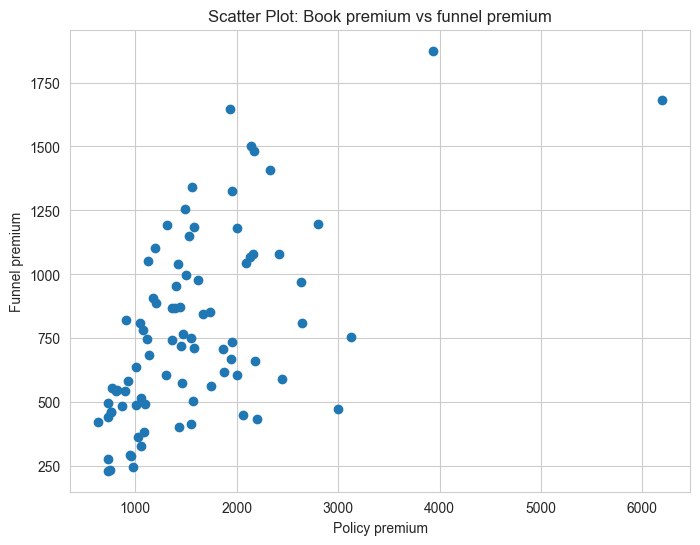

In [254]:
import matplotlib.pyplot as plt

# Create a scatter plot of policy_on_book vs policy_time_remains
plt.figure(figsize=(8, 6))
plt.scatter(tb_df['total_premium'], tb_df['premium'])
plt.xlabel('Policy premium')
plt.ylabel('Funnel premium')
plt.title('Scatter Plot: Book premium vs funnel premium')
plt.grid(True)
plt.show()

In [255]:
tb_df['total_premium_surcharge'] =tb_df['total_premium'] - tb_df["premium"]

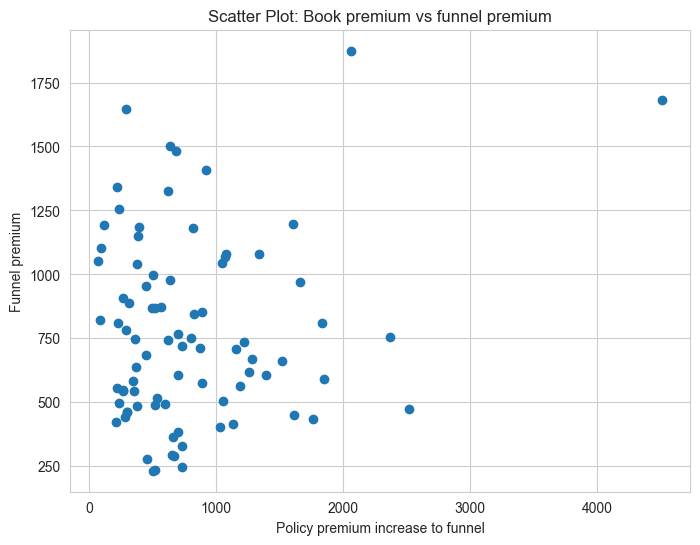

In [256]:
import matplotlib.pyplot as plt

# Create a scatter plot of policy_on_book vs policy_time_remains
plt.figure(figsize=(8, 6))
plt.scatter(tb_df['total_premium_surcharge'], tb_df['premium'])
plt.xlabel('Policy premium increase to funnel')
plt.ylabel('Funnel premium')
plt.title('Scatter Plot: Book premium vs funnel premium')
plt.grid(True)
plt.show()

In [257]:
tb_df[["policy_number",'policy_start_date','policy_continuation_date','policy_on_book', 'policy_time_remains','policy_term','policy_time_to_continuation',"churn"]]

,policy_number,policy_start_date,policy_continuation_date,policy_on_book,policy_time_remains,policy_term,policy_time_to_continuation,churn
0,10295.0,2019-02-09,2020-02-09,265,100.0,365.0,365.0,0
1,10344.0,2019-03-05,2020-03-01,241,121.0,362.0,362.0,0
2,10347.0,2019-04-01,2020-04-01,214,152.0,366.0,366.0,0
3,10382.0,2019-03-20,2020-03-20,226,140.0,366.0,366.0,0
4,10387.0,2019-04-01,2020-04-01,214,152.0,366.0,366.0,0
...,...,...,...,...,...,...,...,...
490,11908.0,2020-03-15,NaT,-135,NaN,NaN,NaN,-1
491,11909.0,2020-03-02,NaT,-122,NaN,NaN,NaN,-1
492,11912.0,2020-02-29,NaT,-120,NaN,NaN,NaN,-1
493,11917.0,2020-03-01,NaT,-121,NaN,NaN,NaN,-1


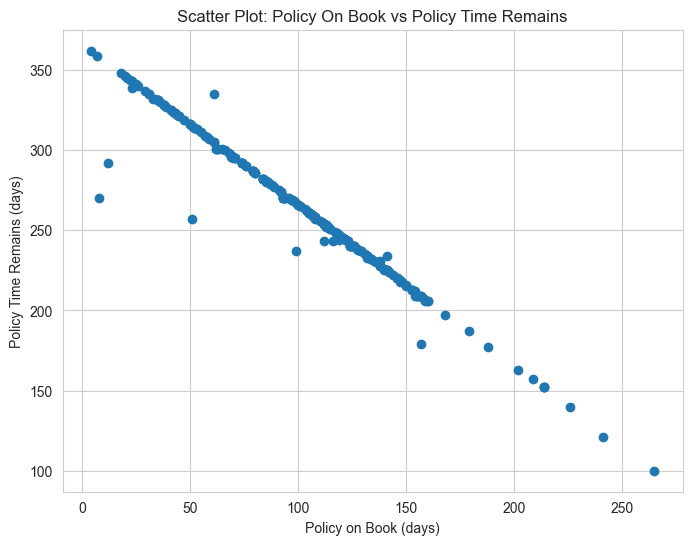

In [258]:
import matplotlib.pyplot as plt

# Create a scatter plot of policy_on_book vs policy_time_remains
plt.figure(figsize=(8, 6))
plt.scatter(tb_df['policy_on_book'], tb_df['policy_time_remains'])
plt.xlabel('Policy on Book (days)')
plt.ylabel('Policy Time Remains (days)')
plt.title('Scatter Plot: Policy On Book vs Policy Time Remains')
plt.grid(True)
plt.show()

In [259]:
tb_df['policy_time_to_continuation'].fillna(0).astype(int).value_counts()

policy_time_to_continuation
0      247
366    197
365     21
364     10
363      8
362      2
336      2
375      1
369      1
359      1
355      1
308      1
278      1
396      1
304      1
Name: count, dtype: int64

In [260]:
# If these columns had decimals, we would round them:
tb_df['policy_on_book'] = tb_df['policy_on_book'].fillna(0).round(0).astype(int)
tb_df['policy_time_remains'] = tb_df['policy_time_remains'].fillna(0).round(0).astype(int)
tb_df['policy_term'] = tb_df['policy_term'].fillna(0).round(0).astype(int)
tb_df['policy_time_to_continuation'] = tb_df['policy_time_to_continuation'].fillna(0).round(0).astype(int)


# Create a pivot table counting policy_number for each combination of the three columns
pivot_df = tb_df.pivot_table(
    index=['policy_on_book', 'policy_time_remains', 'policy_term', 'policy_time_to_continuation'],
    values='policy_number',
    aggfunc='count'
).reset_index().rename(columns={'policy_number': 'count_policy_number'})

pivot_df

,policy_on_book,policy_time_remains,policy_term,policy_time_to_continuation,count_policy_number
0,-405,0,0,0,1
1,-148,0,0,0,1
2,-147,0,0,0,1
3,-138,0,0,0,1
4,-135,0,0,0,1
...,...,...,...,...,...
266,209,157,366,366,1
267,214,152,366,366,3
268,226,140,366,366,1
269,241,121,362,362,1


### 1.3.2. Policy by type

In [261]:
# Assume tb_df has exactly these three columns, each = "Y" or NaN:
#    tb_df['wa'], tb_df['wa_bep_ca'], tb_df['wa_ca']

# 1. Build boolean conditions based on == "Y"
conditions = [
    tb_df['wa'] == 'Y',
    tb_df['wa_bep_ca'] == 'Y',
    tb_df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
tb_df['coverage_type'] = np.select(conditions, choices, default="NA")

# 4. (Optional) If you’d rather have a literal "Unknown" instead of NaN:
tb_df['coverage_type'] = tb_df['coverage_type'].fillna('Unknown')

In [262]:
policy_types = (
    tb_df
    .pivot_table(
        index=["coverage_type","churn"],
        values=["premium", "premium_wa", "premium_other", "policy_number","bonus_malus_percent"],
        aggfunc={
            "premium": "mean",
            "premium_wa": "mean",
            "premium_other": "mean",
            "policy_number": lambda x: len(x.unique()),
            "bonus_malus_percent": "mean"
        }
    )
    .reset_index()
)

policy_types

,coverage_type,churn,bonus_malus_percent,policy_number,premium,premium_other,premium_wa
0,1. Only liability insurance,-1,NaN,108,621.556574,NaN,NaN
1,1. Only liability insurance,0,52.993827,163,629.878466,68.815000,1047.909816
2,1. Only liability insurance,1,NaN,43,608.672558,NaN,NaN
3,2. Liability + limited casco,-1,NaN,28,489.735714,NaN,NaN
4,2. Liability + limited casco,0,55.762712,59,765.622034,415.257966,975.350678
5,2. Liability + limited casco,1,NaN,9,643.706667,NaN,NaN
6,3. Liability + full casco,-1,NaN,55,655.756000,NaN,NaN
7,3. Liability + full casco,0,65.884615,26,809.391154,1154.717692,937.355769
8,3. Liability + full casco,1,NaN,4,856.800000,NaN,NaN


In [263]:
tb_df[["policy_number","premium","premium_wa","premium_other"]]

,policy_number,premium,premium_wa,premium_other
0,10295.0,233.07,570.94,186.53
1,10344.0,290.88,725.12,236.24
2,10347.0,619.73,912.12,1011.78
3,10382.0,343.20,1113.90,7.49
4,10387.0,243.36,817.26,NaN
...,...,...,...,...
490,11908.0,417.96,NaN,NaN
491,11909.0,560.88,NaN,NaN
492,11912.0,634.44,NaN,NaN
493,11917.0,892.92,NaN,NaN


## 1.4. SOCIO-CULTURAL

In [264]:
code_map = {
    1: 1,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    0: 0
}

cols_to_recode = [
    "SOCCL_A", "SOCCL_B1", "SOCCL_B2",
    "SOCCL_C", "SOCCL_D",
    "EDU_HIGH", "EDU_MID", "EDU_LOW"
]


In [265]:
tb_df[cols_to_recode] = tb_df[cols_to_recode].replace(code_map)

In [266]:
soccl_cols = ["SOCCL_A", "SOCCL_B1", "SOCCL_B2", "SOCCL_C", "SOCCL_D"]

# ── (4) Compute the row-wise mean (float), then round to nearest integer
tb_df["SOCCL_mean_raw"] = tb_df[soccl_cols].fillna(0).mean(axis=1)

# ── (5) Round to nearest integer and cast to int
tb_df["SOCCL_mean_rounded"] = tb_df["SOCCL_mean_raw"].round().astype(int)

In [267]:
# ── (1) List the three EDU columns
edu_cols = ["EDU_HIGH", "EDU_MID", "EDU_LOW"]

# ── (2) Compute their row-wise average (float)
tb_df["EDU_mean_raw"] = tb_df[edu_cols].fillna(0).mean(axis=1)

# ── (3) Round to nearest integer (0–5) and cast to int
tb_df["EDU_mean_rounded"] = tb_df["EDU_mean_raw"].round().astype(int)

In [268]:
code_map = {
    1: "1. 0-25%",
    2: "2. 25-50%",
    3: "3. 50-75%",
    4: "4. 75-100%",
    0: "6. unknown"
}

In [269]:
# ── (6) Map that rounded integer to the human-readable label
tb_df["SOCCL_mean_label"] = tb_df["SOCCL_mean_rounded"].map(code_map)

# ── (4) Map that to the same code_map
tb_df["EDU_mean_label"] = tb_df["EDU_mean_rounded"].map(code_map)

In [270]:
print(
    tb_df[
        soccl_cols
        + ["SOCCL_mean_raw", "SOCCL_mean_rounded", "SOCCL_mean_label"]
        + edu_cols
        + ["EDU_mean_raw", "EDU_mean_rounded", "EDU_mean_label"]
    ]
    .head(10)
)

   SOCCL_A  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  SOCCL_mean_raw  \
0      3.0       2.0       1.0      1.0      1.0             1.6   
1      4.0       2.0       1.0      1.0      1.0             1.8   
2      2.0       3.0       1.0      1.0      1.0             1.6   
3      1.0       3.0       1.0      1.0      1.0             1.4   
4      1.0       1.0       2.0      2.0      1.0             1.4   
5      4.0       1.0       1.0      1.0      1.0             1.6   
6      2.0       2.0       1.0      1.0      1.0             1.4   
7      4.0       1.0       1.0      1.0      1.0             1.6   
8      1.0       1.0       3.0      2.0      1.0             1.6   
9      1.0       1.0       3.0      1.0      2.0             1.6   

   SOCCL_mean_rounded SOCCL_mean_label  EDU_HIGH  EDU_MID  EDU_LOW  \
0                   2        2. 25-50%       3.0      2.0      1.0   
1                   2        2. 25-50%       3.0      2.0      1.0   
2                   2        2. 25-50%   

In [271]:
tb_df.head()

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,policy_term,total_premium,total_premium_surcharge,coverage_type,SOCCL_mean_raw,SOCCL_mean_rounded,EDU_mean_raw,EDU_mean_rounded,SOCCL_mean_label,EDU_mean_label
0,T&B,Policycreated,1950,10295.0,10608,4634,1966-04-01,RENAULT,2019-02-07,2019-02-07,...,365,749.98,516.91,2. Liability + limited casco,1.6,2,2.000000,2,2. 25-50%,2. 25-50%
1,T&B,Policycreated,2106,10344.0,10684,4838,1956-08-01,FORD,2019-03-04,2019-03-04,...,362,961.36,670.48,2. Liability + limited casco,1.8,2,2.000000,2,2. 25-50%,2. 25-50%
2,T&B,Policycreated,2116,10347.0,10682,3223,1947-02-01,NISSAN,2019-03-05,2019-03-31,...,366,1877.98,1258.25,3. Liability + full casco,1.6,2,2.000000,2,2. 25-50%,2. 25-50%
3,T&B,Policycreated,1645,10382.0,10749,3823,1953-10-01,OPEL,2019-03-18,2019-03-18,...,366,NaN,NaN,1. Only liability insurance,1.4,1,2.000000,2,1. 0-25%,2. 25-50%
4,T&B,Policycreated,2229,10387.0,10762,9733,1978-07-01,OPEL,2019-03-19,2019-03-19,...,366,NaN,NaN,1. Only liability insurance,1.4,1,1.666667,2,1. 0-25%,2. 25-50%


In [272]:
tb_df[cols_to_recode] = tb_df[cols_to_recode].replace(code_map)

print(df.head())

  affinity_name           status_report  offer_number  policy_number  \
0        Insuro        Requestwithdrawn          1000        10000.0   
1         other  Tailoredofferwithdrawn          1001            NaN   
2         other       Incompleterequest          1002            NaN   
3         other           Policycreated          1003        10002.0   
4         other           Policycreated          1004        10003.0   

   zipcode_link  zip4  birth_date       brand  date_offer date_request  ...  \
0         10000  2132  1985-01-01     HYUNDAI  2018-10-11   2018-10-11  ...   
1         10001  6027  1987-04-01        AUDI  2018-10-11          NaN  ...   
2         10002  3824  1972-11-01  VOLKSWAGEN  2018-10-11          NaN  ...   
3         10003  6921  1983-08-01       MAZDA  2018-10-11   2018-10-11  ...   
4         10004  8266  1990-04-01       VOLVO  2018-10-12   2018-10-12  ...   

  FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD LOAN SAVINGS SHOP_ONLINE  CAR  \
0          

In [273]:
social_a_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_A"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
    )
    .reset_index()
)

social_a_pivot

,SOCCL_A,policy_number,premium
0,1. 0-25%,348,669.266494
1,2. 25-50%,57,598.389474
2,3. 50-75%,50,616.011200
3,4. 75-100%,35,536.378571


In [274]:
social_b1_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_B1"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
    )
    .reset_index()
)

social_b1_pivot

,SOCCL_B1,policy_number,premium
0,1. 0-25%,292,661.218904
1,2. 25-50%,125,607.713680
2,3. 50-75%,65,653.246462
3,4. 75-100%,8,635.700000


In [275]:
social_b2_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_B2"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
    )
    .reset_index()
)

social_b2_pivot

,SOCCL_B2,policy_number,premium
0,1. 0-25%,232,617.325948
1,2. 25-50%,164,658.377317
2,3. 50-75%,83,691.082048
3,4. 75-100%,11,730.312727


In [276]:
social_c_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_C"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
    )
    .reset_index()
)

social_c_pivot

,SOCCL_C,policy_number,premium
0,1. 0-25%,338,624.224586
1,2. 25-50%,109,714.607339
2,3. 50-75%,37,660.495135
3,4. 75-100%,6,544.720000


In [277]:
social_d_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_D"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "mean"
        }
    )
    .reset_index()
)

social_d_pivot

,SOCCL_D,policy_number,premium
0,1. 0-25%,390,636.959769
1,2. 25-50%,61,699.421639
2,3. 50-75%,33,650.258182
3,4. 75-100%,6,674.866667


In [278]:
edu_high_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_HIGH"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_high_pivot

,EDU_HIGH,policy_number,premium
0,1. 0-25%,340,226559.74
1,2. 25-50%,49,30536.33
2,3. 50-75%,42,23499.17
3,4. 75-100%,59,35991.51


In [279]:
edu_mid_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_MID"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_mid_pivot

,EDU_MID,policy_number,premium
0,1. 0-25%,177,114620.19
1,2. 25-50%,123,76699.42
2,3. 50-75%,112,70396.59
3,4. 75-100%,78,54870.55


In [280]:
edu_low_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_LOW"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_low_pivot

,EDU_LOW,policy_number,premium
0,1. 0-25%,243,151761.09
1,2. 25-50%,69,45107.98
2,3. 50-75%,70,47003.52
3,4. 75-100%,108,72714.16


In [281]:
social_mean_pivot = (
    tb_df
    .pivot_table(
        index=["SOCCL_mean_rounded","SOCCL_mean_label"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

social_mean_pivot

,SOCCL_mean_rounded,SOCCL_mean_label,policy_number,premium
0,0,6. unknown,5,4600.08
1,1,1. 0-25%,223,142327.07
2,2,2. 25-50%,267,174259.68


In [282]:
edu_mean_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_mean_rounded","EDU_mean_label"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_mean_pivot

,EDU_mean_rounded,EDU_mean_label,policy_number,premium
0,0,6. unknown,5,4600.08
1,2,2. 25-50%,490,316586.75


In [283]:
edu_mean_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_HIGH"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_mean_pivot

,EDU_HIGH,policy_number,premium
0,1. 0-25%,340,226559.74
1,2. 25-50%,49,30536.33
2,3. 50-75%,42,23499.17
3,4. 75-100%,59,35991.51


In [284]:
edu_mid_pivot = (
    tb_df
    .pivot_table(
        index=["EDU_MID"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

edu_mid_pivot

,EDU_MID,policy_number,premium
0,1. 0-25%,177,114620.19
1,2. 25-50%,123,76699.42
2,3. 50-75%,112,70396.59
3,4. 75-100%,78,54870.55


In [285]:
dink_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "1. Minority",
    4: "1. Minority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["DINK_norm"] = tb_df["DINK"].replace(dink_code_map)

In [286]:
dink_pivot = (
    tb_df
    .pivot_table(
        index=["DINK_norm"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

dink_pivot

,DINK_norm,policy_number,premium
0,1. Minority,338,218065.13
1,2. Majority,152,98521.62


In [287]:
car_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "2. Majority",
    4: "2. Majority",
    5: "2. Majority",
    0: "3. Unknown"
}

tb_df["CAR_norm"] = tb_df["CAR"].replace(car_code_map)

In [288]:
car_pivot = (
    tb_df
    .pivot_table(
        index=["CAR_norm"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

car_pivot

,CAR_norm,policy_number,premium
0,1. Minority,162,109403.17
1,2. Majority,328,207183.58


In [289]:
shop_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "1. Minority",
    4: "1. Minority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["SHOP_norm"] = tb_df["SHOP_ONLINE"].replace(shop_code_map)

In [290]:
shop_pivot = (
    tb_df
    .pivot_table(
        index=["SHOP_norm"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

shop_pivot

,SHOP_norm,policy_number,premium
0,1. Minority,248,162484.28
1,2. Majority,242,154102.47


In [291]:
loan_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "1. Minority",
    4: "2. Majority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["LOAN_norm"] = tb_df["LOAN"].replace(loan_code_map)

In [292]:
loan_pivot = (
    tb_df
    .pivot_table(
        index=["LOAN_norm"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

loan_pivot

,LOAN_norm,policy_number,premium
0,1. Minority,266,158748.69
1,2. Majority,224,157838.06


In [293]:
savings_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "2. Majority",
    4: "2. Majority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["SAVINGS_norm"] = tb_df["SAVINGS"].replace(savings_code_map)

In [294]:
savings_pivot = (
    tb_df
    .pivot_table(
        index=["SAVINGS_norm"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

savings_pivot

,SAVINGS_norm,policy_number,premium
0,1. Minority,71,49843.04
1,2. Majority,419,266743.71


In [295]:
savings_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "2. Majority",
    4: "2. Majority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["SAVINGS_norm"] = tb_df["SAVINGS"].replace(savings_code_map)

In [296]:
# 1. Define the mapping from integer code → descriptive label
stage_map = {
    0: "unknown",
    1: "young singles",
    2: "adult singles",
    3: "older singles",
    4: "families with young children",
    6: "families with older children",
    7: "young couples without children",
    8: "adult couples without children",
    9: "older couples without children"
    # Note: code 5 is not defined here; any 5s will become NaN unless you add a mapping.
}

# 2. Apply that mapping to create a new column
tb_df["STAGE_OF_LIFE_label"] = tb_df["STAGE_OF_LIFE"].map(stage_map)

# 3. (Optional) If you’d rather keep “5” as “unknown” too, you could do:
# stage_map[5] = "unknown"
# tb_df["STAGE_OF_LIFE_label"] = tb_df["STAGE_OF_LIFE"].map(stage_map)

# 4. Quick check
print(tb_df[["STAGE_OF_LIFE", "STAGE_OF_LIFE_label"]].head())

   STAGE_OF_LIFE             STAGE_OF_LIFE_label
0            4.0    families with young children
1            9.0  older couples without children
2            9.0  older couples without children
3            6.0    families with older children
4            6.0    families with older children


In [297]:
stage_pivot = (
    tb_df
    .pivot_table(
        index=["STAGE_OF_LIFE","STAGE_OF_LIFE_label"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

stage_pivot

,STAGE_OF_LIFE,STAGE_OF_LIFE_label,policy_number,premium
0,1.0,young singles,71,48176.17
1,2.0,adult singles,71,48684.92
2,3.0,older singles,55,30639.29
3,4.0,families with young children,116,81817.17
4,6.0,families with older children,77,49474.89
5,7.0,young couples without children,14,9155.75
6,8.0,adult couples without children,9,6799.14
7,9.0,older couples without children,75,40809.82


In [298]:
avg_house_map = {
    0:  "unknown",
    1:  "<75k",
    2:  "75k-150k",
    3:  "150k-225k",
    4:  "225k-300k",
    5:  "300k-375k",
    6:  "375k-450k",
    7:  "450k-525k",
    8:  "525k-600k",
    9:  "600k-675k",
    10: "675k-750k",
    11: "750k-825k",
    12: "825k-900k",
    13: "900k-975k",
    14: "975k-1050k",
    15: ">1050k"
}
tb_df["AVG_HOUSE_label"] = tb_df["AVG_HOUSE"].map(avg_house_map)

In [299]:
house_pivot = (
    tb_df
    .pivot_table(
        index=["AVG_HOUSE","AVG_HOUSE_label"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

house_pivot

,AVG_HOUSE,AVG_HOUSE_label,policy_number,premium
0,1.0,<75k,8,4219.76
1,2.0,75k-150k,35,25405.20
2,3.0,150k-225k,54,33782.12
3,4.0,225k-300k,70,54178.88
4,5.0,300k-375k,65,42429.28
5,6.0,375k-450k,51,34055.94
6,7.0,450k-525k,44,30779.52
7,8.0,525k-600k,29,16507.92
8,9.0,600k-675k,62,35036.85
9,10.0,675k-750k,38,20268.43


In [300]:
savings_code_map = {
    1: "1. Minority",
    2: "1. Minority",
    3: "2. Majority",
    4: "2. Majority",
    5: "2. Majority",
    6: "2. Majority",
    0: "3. Unknown"
}

tb_df["SAVINGS_norm"] = tb_df["SAVINGS"].replace(savings_code_map)

In [301]:
avg_house_pivot = (
    tb_df
    .pivot_table(
        index=["STAGE_OF_LIFE","STAGE_OF_LIFE_label"],
        values=["policy_number","premium"],
        aggfunc={
            "policy_number": lambda x: len(x.unique()),
            "premium": "sum"
        }
    )
    .reset_index()
)

avg_house_pivot

,STAGE_OF_LIFE,STAGE_OF_LIFE_label,policy_number,premium
0,1.0,young singles,71,48176.17
1,2.0,adult singles,71,48684.92
2,3.0,older singles,55,30639.29
3,4.0,families with young children,116,81817.17
4,6.0,families with older children,77,49474.89
5,7.0,young couples without children,14,9155.75
6,8.0,adult couples without children,9,6799.14
7,9.0,older couples without children,75,40809.82


## EXCEL OUTPUT

In [302]:
def append_df_to_excel(df, excel_path, sheet_name, table_style=None):
    """
    Append *df* to *excel_path* in a new sheet called *sheet_name*.
    Creates the file if it doesn't exist yet.
    Optionally formats the range as an Excel 'Table' (striped style)  
    if you pass a *table_style* string, e.g. "TableStyleMedium9".
    """
    # Figure out whether the file already exists
    file_exists = os.path.exists(excel_path)

    # 1️⃣  Open writer in append ('a') or write ('w') mode
    with pd.ExcelWriter(
            excel_path,
            engine="openpyxl",
            mode="a" if file_exists else "w",
            # **NO** if_sheet_exists parameter → appends when the name is new
    ) as writer:
        if file_exists and sheet_name in writer.book.sheetnames:
            raise ValueError(f"'{sheet_name}' already exists! Pick another name.")

        # 2️⃣  Dump the DataFrame
        df.to_excel(writer, sheet_name=sheet_name, index=False)

        # 3️⃣  Optional: convert range to an Excel Table (nice stripes)
        if table_style:
            from openpyxl.worksheet.table import Table, TableStyleInfo

            ws = writer.book[sheet_name]
            max_row, max_col = ws.max_row, ws.max_column
            last_col = chr(ord("A") + max_col - 1)      # crude col-letter calc
            excel_range = f"A1:{last_col}{max_row}"

            tbl = Table(displayName=sheet_name.replace(" ", "_"), ref=excel_range)
            tbl.tableStyleInfo = TableStyleInfo(name=table_style,
                                                showRowStripes=True,
                                                showColumnStripes=False)
            ws.add_table(tbl)


In [303]:
sheets = {
    "AgePivot":    age_pivot,      # DataFrame with age-band × gender counts
    "GenderPivot": gender_pivot,    # DataFrame with overall gender counts
    "ResidencePivot": residence_pivot,
    "IncomePivot": income_pivot,
    "UrbanPivot": urb_pivot,
    "NumCars": num_cars,
    "BrandPivot": brand_pivot,
    "AgeCars": age_cars,
    "PricesCars": prices_cars,
    "FuelCars": fuel_cars,
    "PolicyTypes": policy_types,
    "SocMean": social_mean_pivot,
    "EduMean": edu_mean_pivot,
    "DinkPivot": dink_pivot,
    "StagePivot": stage_pivot,
    "HousePivot": house_pivot
}

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    workbook = writer.book

    for sheet_name, df in sheets.items():
        # 2-a. Dump the DataFrame
        df.to_excel(writer, sheet_name=sheet_name, startrow=0, startcol=0,
                    index=False)

        # 2-b. Turn that range into a nicely styled Excel Table
        worksheet = writer.sheets[sheet_name]
        max_row, max_col = df.shape            # rows & cols in the DataFrame
        table_range = (0, 0, max_row, max_col-1)  # (first_row, first_col, ...)

        worksheet.add_table(*table_range, {
            "name":       sheet_name.replace(" ", "_"),
            "columns":    [{"header": col} for col in df.columns],
            "style":      "Table Style Medium 9",
        })

        # 2-c. Auto-fit the column widths (simple heuristic)
        for i, col in enumerate(df.columns):
            col_width = max(len(str(col)), 12)                # header width
            try:
                col_width = max(col_width, int(df[col].astype(str).str.len().max()))
            except ValueError:                                # empty col
                pass
            worksheet.set_column(i, i, col_width + 2)         # +2 padding